In [2]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime

In [3]:
import sys
sys.path.append("../iSBatch")
import iSBatch as rqs

In [4]:
color_list = [i for i in mcolors.TABLEAU_COLORS]
marker_list = ["o", "x"]

# Analyze the VU log
### Resource underestimation statistics

In [5]:
def time_converter(data):
    x = data.split('-')
    if len(x)==1:
        d = 0
        x = x[0]
    else:
        d = int(x[0])
        x = x[1]
    h,m,s = map(int,x.split(':'))
    return (d*24 + h)*60 + m + s/60

In [6]:
def memory_size_converter(size):
    num = float(size.rstrip('K'))
    return num / 1024

In [7]:
inf = open("liver_ai_job_stats.txt", "r")
data = [] 
for line2 in inf:
    line2 = line2.split("\n")[0].split(" ")
    line = [i for i in line2 if i!=""]
    if len(line)<2:
        print(line2, line)
    if line[0] == 'imgvuacr':
        data.append([line[1], line[4], time_converter(line[5]),
                     line[6], line[7], time_converter(line[8]),
                     0, 0, line[9], line[10], line[2]])
    if line[1] == 'batch':
        if line[6][-1] == 'K' and line[7][-1] == 'K':
            data[-1][6] = memory_size_converter(line[6])
            data[-1][7] = memory_size_converter(line[7])
    if line[1] == 'extern':
        if line[2] != data[-1][1]:
            if data[-1][1] != 'TIMEOUT':
                #print(data[-1][0], "extern", line[2], data[-1][1])
                data[-1][1] = line[2]
        if data[-1][6] == 0 and data[-1][7] == 0:
            data[-1][6] = memory_size_converter(line[6])
            data[-1][7] = memory_size_converter(line[7])
inf.close()
data[0]

['7106651',
 'COMPLETED',
 60.0,
 '2019-03-13T15:24:22',
 '2019-03-13T15:40:19',
 15.95,
 9999.65625,
 141.05859375,
 '1',
 '1',
 'liver_ai_+']

In [8]:
df = pd.DataFrame(data, columns=['JobID', 'State', 'Timelimit', 'Start',
                                 'End', 'Elapsed', 'MaxRSS', 'MaxVMSize',
                                 'NNodes', 'NCPUS', 'JobName'])
df = df[df.JobName != 'test.slurm']
data = [i for i in data if i[10] != 'test.slurm']
df['Memory'] = (df['MaxRSS'] + df['MaxVMSize']) / 1024
df.head()

,JobID,State,Timelimit,Start,End,Elapsed,MaxRSS,MaxVMSize,NNodes,NCPUS,JobName,Memory
0,7106651,COMPLETED,60.0,2019-03-13T15:24:22,2019-03-13T15:40:19,15.950000,9999.656250,141.058594,1,1,liver_ai_+,9.903042
1,7106946,COMPLETED,60.0,2019-03-13T15:48:31,2019-03-13T16:46:38,58.116667,9999.738281,141.058594,1,1,liver_ai_+,9.903122
2,7121508,COMPLETED,60.0,2019-03-14T10:31:54,2019-03-14T10:48:22,16.466667,9999.917969,141.078125,1,1,liver_ai_+,9.903316
3,7121796,COMPLETED,60.0,2019-03-14T10:55:58,2019-03-14T11:10:29,14.516667,9999.683594,141.058594,1,1,liver_ai_+,9.903069
4,7122856,COMPLETED,60.0,2019-03-14T11:53:13,2019-03-14T12:12:42,19.483333,9999.656250,141.058594,1,1,liver_ai_+,9.903042


In [9]:
df["State"].unique()

array(['COMPLETED', 'TIMEOUT', 'CANCELLED'], dtype=object)

In [10]:
print("COMPLETED jobs:", len(df[df.State=="COMPLETED"]))
print("TIMEOUT jobs:", len(df[df.State=="TIMEOUT"]))

COMPLETED jobs: 1549
TIMEOUT jobs: 421


In [11]:
df["Timelimit"].unique()

array([ 60., 120., 180., 240., 360.])

In [20]:
for i in df["Timelimit"].unique():
    print("Timeout with %d min requests:" %(i),
          len(df[(df.Timelimit == i) & (df.State == "TIMEOUT")]))

for i in df["Timelimit"].unique():
    print("Potential resubmissions for the %d min requests:" %(i),
          len(df[(df.Timelimit == i*2) & (df.Elapsed > i)]))

Timeout with 60 min requests: 133
Timeout with 120 min requests: 248
Timeout with 180 min requests: 0
Timeout with 240 min requests: 20
Timeout with 360 min requests: 20
Potential resubmissions for the 60 min requests: 508
Potential resubmissions for the 120 min requests: 24
Potential resubmissions for the 180 min requests: 25
Potential resubmissions for the 240 min requests: 0
Potential resubmissions for the 360 min requests: 0


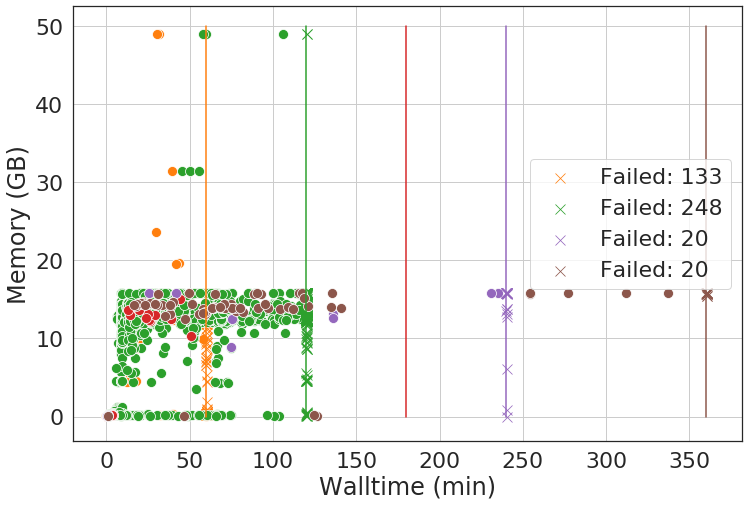

In [23]:
request = df["Timelimit"].drop_duplicates()

sns.set(font_scale=2)
sns.set_style("white")
fig, ax = plt.subplots(figsize=(12,8))

# set the request times
cnt = 1
max_color = len(color_list)
for i in request.values:
    # time in database is in min
    plt.plot([i, i], [0, 50], color=color_list[cnt])
    #plt.plot([0, i], [400, 400], color=color_list[cnt])
    sns.scatterplot(y="Memory", x="Elapsed", marker='o', s=100,
                    data=df[(df.Timelimit == i) & (df.State == "COMPLETED")],
                    color = color_list[cnt])
    len_success = len(df[(df.Timelimit == i) & (df.State == "COMPLETED")])
    len_timeout = len(df[(df.Timelimit == i) & (df.State == "TIMEOUT")])
    sns.scatterplot(y="Memory", x="Elapsed", marker='x', s=100,
                    data=df[(df.Timelimit == i) & (df.State == "TIMEOUT")],
                    color = color_list[cnt],
                    label="Failed: %d" %(len_timeout))
    #print(i, len_success, len_timeout)
    cnt = (cnt + 1) % max_color

plt.grid(True)
ax.set_xlabel('Walltime (min)')
ax.set_ylabel('Memory (GB)')
#ax.set_xscale('log', basex=2)
#ax.set_yscale('log', basey=2)

#plt.savefig("figures/time_fail_%s.png" %(dataset), bbox_inches = 'tight')
plt.show()

# Simulation
### Use iSBatch to make the requests
- Compare results to the log

In [25]:
# get all request timings and the first time they were used
requests = []
for i in data:
    if i[2] not in requests:
        print(i[3], i[2])
        requests.append(i[2])
requests.append(480)

2019-03-13T15:24:22 60.0
2019-04-30T13:02:36 120.0
2019-05-01T13:35:36 180.0
2019-05-13T16:02:14 240.0
2019-06-13T05:11:54 360.0


In [26]:
def same_batch(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%dT%H:%M:%S")
    d2 = datetime.strptime(d2, "%Y-%m-%dT%H:%M:%S")
    if abs((d1 - d2).seconds) > 600:
        return False
    return True

In [113]:
# take all entries up to i and create an array of walltimes
# for successful runs 
def compute_history(ts, data):
    history = [data[i][5] for i in range(ts)
               if data[i][1] == "COMPLETED"]
    next_request = min([i for i in requests if i > data[ts][2]])
    history += [min([j for j in requests if j > data[i][2]])
                for i in range(ts)
                if data[i][1] == "TIMEOUT"]
    return history

def compute_sequence(cnt, data, lower_limit=15, upper_limit=-1):
    history = compute_history(cnt, data)
    params = rqs.ResourceParameters()
    params.CR_strategy=rqs.CRStrategy.NeverCheckpoint
    params.request_lower_limit = lower_limit
    if upper_limit > lower_limit:
        params.request_upper_limit = upper_limit
    wl = rqs.ResourceEstimator(history, params=params)
    sequence = wl.compute_request_sequence()
    return [int(i[0]) for i in sequence]

def extract_full_sequence(sequence, last_req, walltime):
    new_seq = [s for s in sequence if s > last_req and s < walltime]
    temp = [s for s in sequence if s >= walltime]
    if len(temp) > 0:
        new_seq += [min(temp)]
    return new_seq

In [120]:
# create data with merging resubmissions for the same job
log = [] # start_time, elapsed, request
resubmission = {i:[] for i in requests}
isbatch_sequence = requests
for cnt in range(len(data)):
    i = data[cnt]
    add_new = True
    ps = i[2]/2 # get possible previous submission
    if ps == 180: # submissions using 180 do not fail
        ps = 240
    # if there was a job timeout using the previous request
    # and the new walltime exceeds the previous request
    if ps in resubmission and len(resubmission[ps]) > 0 and i[5] > ps:
        # mark this occurence as a resubmission
        idx = resubmission[ps][0]
        log[idx][3] += extract_full_sequence(
            sequence, max(log[idx][3][-1], ps), i[5])
        log[idx][2].append(i[2])
        log[idx][1] = i[5]
        del resubmission[ps][0]
        add_new = False

    # if the current submission is a timeout
    if i[2] <= i[5] or i[1] == "TIMEOUT":
        # add it to the log only if the current submission is not
        # a resubmission
        if add_new:
            log.append([i[3], i[5], [i[2]], [sequence[0]]])
            idx = len(log) - 1
        resubmission[i[2]].append(idx)
        add_new = False

    if i[1] == "COMPLETED" and add_new:
            log.append([i[3], i[5], [i[2]], extract_full_sequence(
                sequence, 0, i[5])])

    if cnt > 0 and same_batch(data[cnt][3], data[cnt - 1][3]):
        continue

    if cnt > 10:
        sequence = compute_sequence(cnt, data)

[i for i in log if i[0]=="2019-04-19T14:06:23"][:2]

[['2019-04-19T14:06:23', 74.2, [60.0, 120.0], [39, 120]],
 ['2019-04-19T14:06:23', 73.95, [60.0, 120.0], [39, 120]]]

In [121]:
log[-2:]

[['2019-06-14T14:04:09', 0.3, [240.0], [34]],
 ['2019-06-14T17:17:12', 74.63333333333334, [240.0], [34, 180]]]

In [111]:
sequence = compute_sequence(len(data)-1, data)
sequence

[34, 180, 480]

### Based on the requests 
- Compute the total failures
- Wasted time due to overestimation

In [124]:
# fails + wasted time for each submission
outcome = []
fail = 0
for i in range(len(log)):
    run = log[i]
    # add all the failed reservation
    fail += len([i for i in run[2] if i < run[1]])
    success = [i for i in run[2] if i >= run[1]]
    if len(success)==0:
        continue
    outcome.append(min(success) - run[1])

print("out of %d runs, %d failed" %(len(data), fail))
np.mean(outcome)

out of 1971 runs, 416 failed


95.60846203346203

In [125]:
# fails + wasted time for each submission with isbatch
outcome = []
fail = 0
for i in range(len(log)):
    run = log[i]
    # add all the failed reservation
    fail += len([i for i in run[3] if i < run[1]])
    success = [i for i in run[3] if i >= run[1]]
    if len(success)==0:
        continue
    outcome.append(min(success) - run[1])

print("out of %d runs, %d failed" %(len(data), fail))
np.mean(outcome)

out of 1971 runs, 971 failed


77.13899234429961